<h3>CMM Sample Data Crustal Thickness Analysis III - Method, Results, and Interpretation</h3>

__Notebook Initial Creation:__ 1/26/2017 <br>
__Author:__ pjparis

__This notebook continues the thread developed in notebook: CMM Sample Data (20k pnts) Crustal Thickness Analysis II__

We're still looking for the OCT - Perhaps we've found it, or something reasonably close?

<h4>Initial Data Load:</h4>

In [7]:
fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/GCS_EDA_sampling/'
file='CMM_20krandompnts.csv'

df = pd.read_csv(fpath+file, names=['ID','CrustThk','Elevation','Magnetic','Gravity','gForms','Lon','Lat'], skiprows=1).dropna()

<h4>Data Preprocessing:</h4>

In [10]:
# import the Matplotlib plotting handlers:
from matplotlib import pyplot as plt

%matplotlib inline

# Render crustal thickness as positive values. Prior were all measured as
# distances from the sea bed to base of crust (Moho) so < 0:
df.CrustThk = df.CrustThk* -1

# build the arrays needed for the Natural Breaks from the df:
X = df.ix[:,1:5]                # extract the continuous numeric fields in df
y = np.array(df.ix[:,5] )       # extract the geomorphon type classifier field only


In [14]:
# extract all records from the df where elevation < 0:
df_wet = df.query('Elevation < 0.0')

# extract all records from the df where elevation >= 0:
df_dry = df.query('Elevation >= 0.0')

<h4>Cluster Procs.</h4>

In [6]:
import sys
sys.path.append('/Users/paulp/Dropbox/PythonLibraries')
                
import FJ_NaturalBreaks as NaturalBreaks

N-B Functions Loaded...


In [50]:
# run the submerged subset of crustal thickness sample data:

data_array=df_wet.ix[:,1]     # extract the crustal thickness field from the overall dataframe
num_classes=2
gvf_threshold=0.8

breaks=ComputeClusterBndys(data_array, num_classes, gvf_threshold)

print('Done')
print()
print('Natural Breaks Optimization Result:')
print(breaks)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Done

Natural Breaks Optimization Result:
[array([ 11.480164,  15.555084,  22.302797,  44.235935])]


__Mean Shift Clusters:__

Number of Clusters: 2


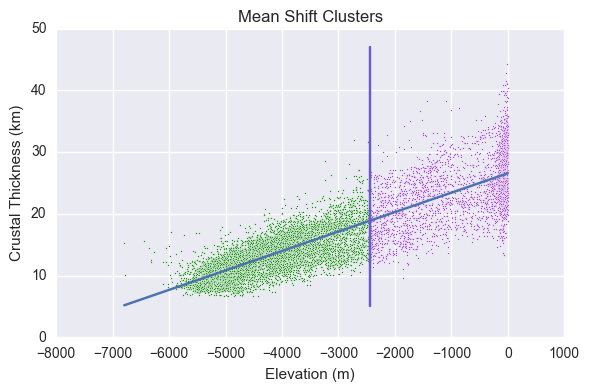

In [253]:
from sklearn.cluster import MeanShift, estimate_bandwidth

X = np.array(df_wet.ix[:,1:3])

bw = estimate_bandwidth(X)
msc = MeanShift(bw, bin_seeding=True).fit(X)
labels = msc.labels_
cluster_centers = msc.cluster_centers_

for k , col in zip(range( len(np.unique(msc.labels_)) ), ['green','darkorchid','m']):
    members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X[members,1], X[members, 0], c=col, marker='.', edgecolor='white', s=5)
    
# fit GLM line to df_wet data:
plt.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))

# plot cluster separation line, as computered below:
plt.plot((-2442, -2442),(5,47), c='slateblue')

plt.xlabel('Elevation (m)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Mean Shift Clusters')
plt.tight_layout()
print('Number of Clusters:', len(cluster_centers))
plt.show()

From earlier results (refer to the prior notebook Part II for details):

As a first approximation and estimate (to test) for the OCT: <br>
crust < 18.9 km is classed as oceanic <br>
crust > 18.9 km is classed as continental 

In [ ]:
# In GRASS: first, extract all GEBCO topobathy data that is underlain by crust > 18.9 km thick:

r.mapcalc
GEBCO_contcrust_189km_30sec = if(GEMMA_CrustThkness_Globala_30sec < -18.9, GEBCO_2014_2D, null() )

A quick and informal survey--taking a series of profiles with the resultant continental crust layer generated above superimposed over the GEBCO topobathy--reveals that the 18.9 km transition is to large a thickness threshold. With few if any exceptions noted the resulting extent of continental crust fails to include the base of the profile continental slopes.The OCT, it would appear, occurs at crustal thicknesses < 18.9 km. 

It is also something to consider that there is no single threshold value, but rather some range of values, for the transition marking the OCT. Hmm...

Before abandoning the single value possibility (the idea of a range of values just came to me while surveying the current results) we should perhaps try, just to see what happens, the F-J Natural Breaks bndy: 11.48 km. Since this will incorporate a lot more abyssal areas we might want to add the additional constraint that the surface should be of gform type footslope, slope, or shoulder so as to filter the undesirable deep water geographies. 

In [ ]:
# In GRASS:  build a global geomorphon DSM:

# then, extract the GEBCO topobathy data underlain by crust > 11.48 km thick:
r.mapcalc
GEBCO_contcrust_1148km_30sec = if(GEMMA_CrustThkness_Globala_30sec < -11.48 & , GEBCO_2014_2D, null() )